# Example: plot HMI

[Example Data](https://pan.baidu.com/s/1nwsIcDr?pwd=s5re) <span style="color:gray"></span>

[User Module Download](https://github.com/lydiazly/lydiazly.github.io/raw/main/source/downloads/scripts/sunpy-modules.zip) ([help](https://lydiazly.github.io/usr_sunpy.html))

In [1]:
from __future__ import division, print_function

# Reload user modules automatically
# %load_ext autoreload
# %autoreload 2

# notebook, inline, ...
%matplotlib notebook

from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import sunpy.map
from copy import deepcopy

# To use user modules
import sys
sys.path.append('../modules')

# print('Python version: %s' % sys.version.split('(')[0])  # Python version: 3.6.6 |Anaconda, Inc.| 
# print('SunPy version: %s' % sunpy.__version__)  # SunPy version: 0.9.3

## Read data

In [2]:
fnames = ('data/hmi.B_720s.20150827_052400_TAI.field.fits',
          'data/hmi.B_720s.20150827_052400_TAI.inclination.fits',
          'data/hmi.B_720s.20150827_052400_TAI.azimuth.fits',
          'data/hmi.B_720s.20150827_052400_TAI.disambig.fits')

In [3]:
from usr_sunpy import read_sdo
mapb, mapi, mapa, mapd = list(map(read_sdo, fnames))

hmi.B_720s.20150827_052400_TAI.field.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.inclination.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.azimuth.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.disambig.fits	[4096, 4096]


* Disambiguate:

In [4]:
mapa.data[mapd.data > 3] += 180.

* Transform to vector components:

In [5]:
mapbx = deepcopy(mapb)
mapby = deepcopy(mapb)
mapbz = deepcopy(mapb)
mapbx.data[:] = mapb.data * np.sin(np.deg2rad(mapi.data)) * np.cos(np.deg2rad(mapa.data + 270.))
mapby.data[:] = mapb.data * np.sin(np.deg2rad(mapi.data)) * np.sin(np.deg2rad(mapa.data + 270.))
mapbz.data[:] = mapb.data * np.cos(np.deg2rad(mapi.data))

In [6]:
# Suppress metadata warnings
for i in {mapbx, mapby, mapbz}:
    i.meta['hgln_obs'] = 0.

In [7]:
mapbz

SunPy Map
---------
Observatory:		 SDO
Instrument:		 HMI SIDE1
Detector:		 HMI
Measurement:		 hmi
Wavelength:		 6173.0
Observation Date:	 2015-08-27 05:22:21
Exposure Time:		 0.000000 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.504376 0.504376] arcsec / pix
Reference Pixel:	 [2033.825928 2053.603271] pix
Reference Coord:	 [0. 0.] arcsec
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

* Use `sunpy.instr.aia.aiaprep()` Processes a level 1 AIAMap into a level 1.5 AIAMap.<br>
https://docs.sunpy.org/en/stable/api/sunpy.instr.aia.aiaprep.html

> From **sunpy 0.9.3**, `sunpy.instr.aia.aiaprep()` supports both `AIAMap` & `HMIMap` objects.

**Note**: Improve `aiaprep` in `<python_path>/site-packages/sunpy/instr/aia.py`:<br>
&emsp;&emsp;&emsp;at line: `tempmap = aiamap.rotate(...)`<br>
&emsp;&emsp;&emsp;add `order=3` (recommend, this will keep NaNs) and set `missing=np.nan` in `rotate()`

There is a modified function `aiaprep_usr()` in `usr_sunpy`

In [7]:
# After `aiaprep`:
# - North is aligned with the y axis.
# - Each pixel is 0.6 arcsec across.
# - The center of the sun is at the center of the image.
# This may be a bit slow.

# from sunpy.instr.aia import aiaprep
from usr_sunpy import aiaprep_usr as aiaprep
import warnings
print('level 1 -> level 1.5 ...')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mapbx = aiaprep(mapbx)
    mapby = aiaprep(mapby)
    mapbz = aiaprep(mapbz)
print('level    =', mapbz.meta['lvl_num'])
print('rsun_obs =', mapbz.meta['rsun_obs'] * u.arcsec)
print('r_sun    =', mapbz.meta['r_sun'] * u.pix)

level 1 -> level 1.5 ...
level    = 1.5
rsun_obs = 949.495178 arcsec
r_sun    = 1582.4919633333334 pix


* **Or**, use `rotate()` manually:

In [8]:
# DO NOT execute this cell if `sunpy.instr.aia.aiaprep()` has been called.
# `rotate` function will remove old CROTA keywords.
# This may be a bit slow if order = 3.
if 'lvl_num' not in mapbz.meta or mapbz.meta['lvl_num'] < 1.5:
    order = 3
    scale_factor = (mapbz.scale[0] / 0.6).value
    print('rotate(CCW) & recenter & rescale ...')
    # Suppress warnings of NaNs:
    with np.errstate(invalid='ignore'):
        mapbx = mapbx.rotate(order=order, recenter=True, scale=scale_factor, missing=np.nan)
        mapby = mapby.rotate(order=order, recenter=True, scale=scale_factor, missing=np.nan)
        mapbz = mapbz.rotate(order=order, recenter=True, scale=scale_factor, missing=np.nan)
    print('Rotation angle = %f deg (CCW)' % -mapb.meta['crota2'])

Level 1.5:

In [8]:
mapbz

SunPy Map
---------
Observatory:		 SDO
Instrument:		 HMI SIDE1
Detector:		 HMI
Measurement:		 hmi
Wavelength:		 6173.0
Observation Date:	 2015-08-27 05:22:21
Exposure Time:		 0.000000 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.6 0.6] arcsec / pix
Reference Pixel:	 [2048.5 2048.5] pix
Reference Coord:	 [0. 0.] arcsec
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Check the disk center ('crpix1', 'crpix2'):

In [8]:
# pixel number start from 1
pcenter = ((mapbz.meta['crpix1'] - 1) * u.pix, (mapbz.meta['crpix2'] - 1) * u.pix)
center = mapbz.pixel_to_world(*pcenter)
print('[Image_center] (%.3f, %.3f) pixel = (%7.4f, %7.4f) arcsec  (lon, lat) = (%8.5f, %8.5f) deg' %
      ((mapbz.dimensions.x.value-1.)/2., (mapbz.dimensions.y.value-1.)/2.,
        mapbz.center.Tx.value, mapbz.center.Ty.value,
        mapbz.center.heliographic_stonyhurst.lon.value, mapbz.center.heliographic_stonyhurst.lat.value))
print('[ Disk_center] (%.3f, %.3f) pixel = (%7.4f, %7.4f) arcsec  (lon, lat) = (%8.5f, %8.5f) deg' %
      (pcenter[0].value, pcenter[1].value, center.Tx.value, center.Ty.value,
       center.heliographic_stonyhurst.lon.value, center.heliographic_stonyhurst.lat.value))
print('[ Observation] (lon, lat, radius) = (%g deg, %g deg, %g m)' %
      (mapbz.heliographic_longitude.value, mapbz.heliographic_latitude.value, mapbz.observer_coordinate.radius.value))

[Image_center] (2047.500, 2047.500) pixel = ( 0.3000,  0.3000) arcsec  (lon, lat) = ( 0.01816,  7.10702) deg
[ Disk_center] (2047.500, 2047.500) pixel = ( 0.0000,  0.0000) arcsec  (lon, lat) = ( 0.00000,  7.08900) deg
[ Observation] (lon, lat, radius) = (0 deg, 7.089 deg, 1.51197e+11 m)


A quick look:

<IPython.core.display.Javascript object>


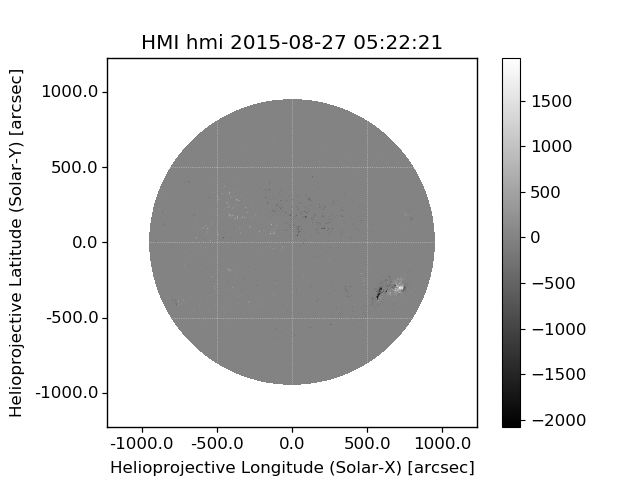

In [9]:
mapbz.peek()

## Plot

https://docs.sunpy.org/en/stable/guide/plotting.html?highlight=peek#plotting-maps-with-wcsaxes

User function `plot_map()` will invoke `plot()` of sunpy.

<IPython.core.display.Javascript object>


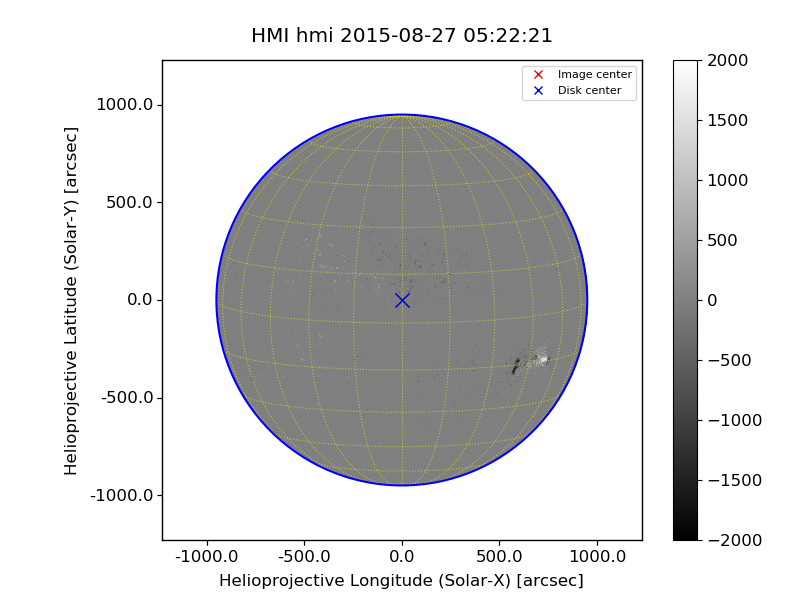

In [9]:
from usr_sunpy import plot_map

fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax1 = fig1.add_subplot(111, projection=mapbz)
# This plot function will simply invoke mapbz.plot(), if keyword `coords` is not specified.
plot_map(mapbz, ax=ax1, vmin=-2000., vmax=2000.)

# Properties
mapbz.draw_limb(axes=ax1, color='b', linewidth=1.5)  # default zorder=100 in `draw_limb()`
ax1.plot_coord(mapbz.center, 'rx', markersize=10, linewidth=1.5, label='Image center')
try:
    ax1.plot_coord(center, 'bx', markersize=10, linewidth=1.5, label='Disk center')
except:
    pass
ax1.legend(loc='upper right', fontsize=8, markerscale=0.6);
# fig1.savefig('example_plothmi_disk.png', dpi=200, bbox_inches='tight')

## Submap

http://docs.sunpy.org/en/v0.9.3/code_ref/map.html?highlight=peek#sunpy.map.mapbase.GenericMap.submap<br>
http://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html

**`submap(bottom_left, top_right=None)`<br>**
* **bottom_left** (astropy.units.Quantity or SkyCoord) – The bottom_left coordinate of the rectangle.<br>
If a SkyCoord it can have shape (2,) and also define top_right.<br>
If specifying pixel coordinates it must be given as an Quantity object with units of pixel.
* **top_right** (astropy.units.Quantity or SkyCoord) – The top_right coordinate of the rectangle.<br>
Can only be omitted if bottom_left has shape (2,).

In [10]:
xrange = (300., 800.) * u.arcsec
yrange = (-500., -100.) * u.arcsec

subcoord = SkyCoord(xrange, yrange, frame=mapbz.coordinate_frame)
smapbx = mapbx.submap(subcoord)
smapby = mapby.submap(subcoord)
smapbz = mapbz.submap(subcoord)
print('Submap: (%s, %s) arcsec  (%d x %d)'
      % (xrange.value, yrange.value, *smapbz.data.shape[::-1]))

Submap: ([300. 800.], [-500. -100.]) arcsec  (833 x 666)


**`draw_rectangle(bottom_left, width, height, axes=None, **kwargs)`**

<IPython.core.display.Javascript object>


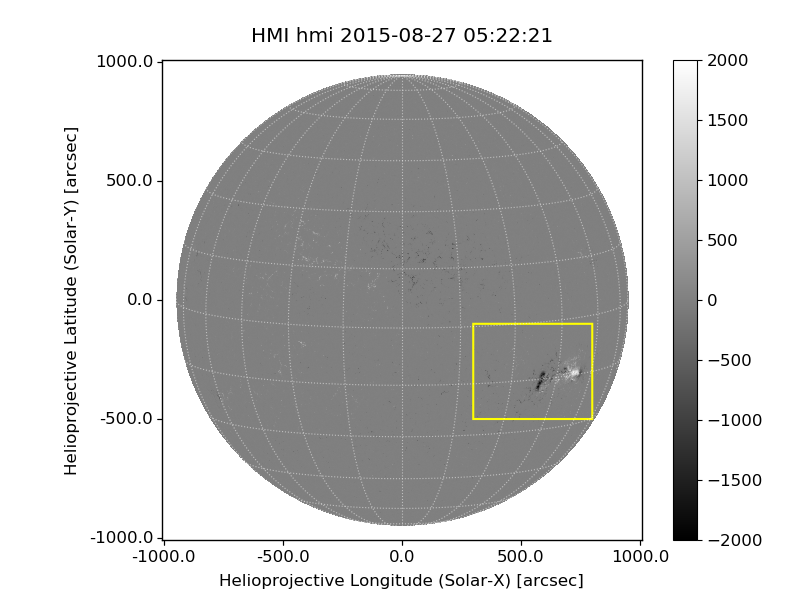

In [11]:
from usr_sunpy import plot_map

fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax1 = fig1.add_subplot(111, projection=mapbz)
plot_map(mapbz, ax=ax1, vmin=-2000., vmax=2000., grid_color='w')

# mapbz.draw_limb(axes=ax1, color='b', linewidth=1.5)
mapbz.draw_rectangle(subcoord[0], xrange[1]-xrange[0], yrange[1]-yrange[0], axes=ax1, color='yellow', linewidth=1.5)

# Specify xlim, ylim by pixels
# lim_arcsec = ((-1000.1, 1000.1) * u.arcsec, (-1000.1, 1000.1) * u.arcsec)
# lim_pix = mapbz.world_to_pixel(SkyCoord(*lim_arcsec, frame=mapbz.coordinate_frame))  # pix
# ax1.set_xlim(lim_pix[0].value)  # pix
# ax1.set_ylim(lim_pix[1].value);  # pix

# Clip NaNs
valid_index = np.where(np.isfinite(mapbz.data))
ax1.set_xlim((valid_index[0].min()-100, valid_index[0].max()+100))  # pix
ax1.set_ylim((valid_index[1].min()-100, valid_index[1].max()+100));  # pix

<IPython.core.display.Javascript object>


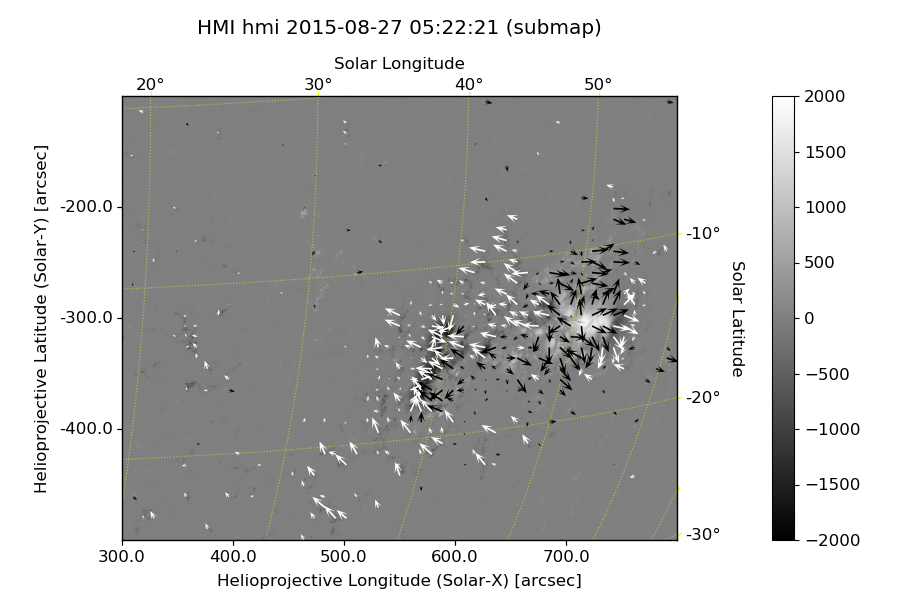

In [12]:
from usr_sunpy import plot_map, plot_vmap

fig2 = plt.figure(figsize=(9, 6), dpi=100)
ax2 = fig2.add_subplot(111, projection=smapbz)
im2 = plot_map(smapbz, ax=ax2, vmin=-2000., vmax=2000., grid=10*u.deg, title=mapbz.latex_name+' (submap)')
plot_vmap(smapbx, smapby, smapbz, ax2, cmin=20., vmax=500., cmap='binary',
          scale_units='xy', scale=1/0.05, minlength=0.02);

### Without disambiguation:

<IPython.core.display.Javascript object>


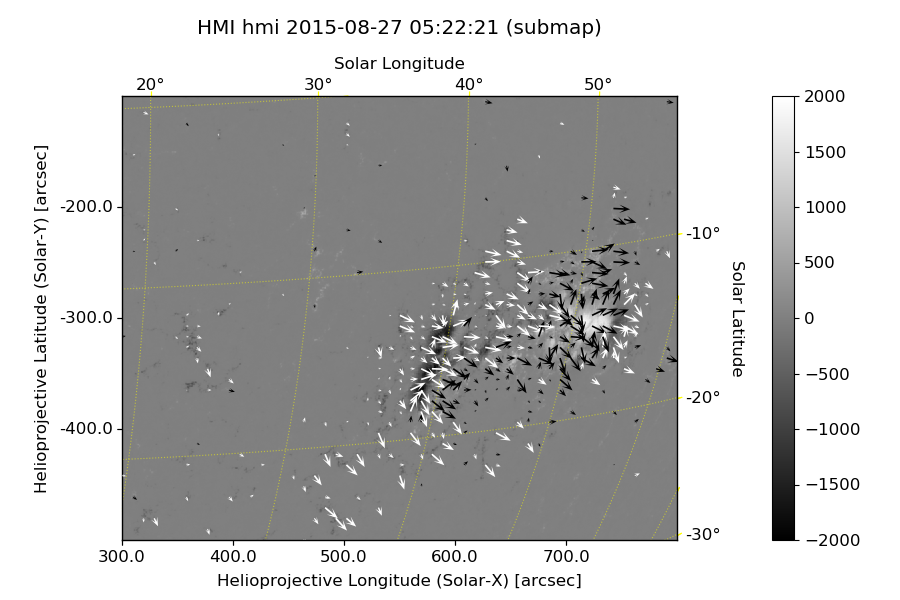

In [9]:
from usr_sunpy import plot_map, plot_vmap

fig2 = plt.figure(figsize=(9, 6), dpi=100)
ax2 = fig2.add_subplot(111, projection=smapbz)
im2 = plot_map(smapbz, ax=ax2, vmin=-2000., vmax=2000., grid=10*u.deg, title=mapbz.latex_name+' (submap)')
plot_vmap(smapbx, smapby, smapbz, ax2, cmin=20., vmax=500., cmap='binary',
          scale_units='xy', scale=1/0.05, minlength=0.02);